# Validation of *CoastSat* at Narrabeen-Collaroy, Australia

This notebook shows a validation of satellite-derived shorelines against *in situ* shoreline data at Narrabeen-Collaroy, Australia. The surveyed shorelines can be downloaded from http://narrabeen.wrl.unsw.edu.au/ (please register an account and download the data). A code to process the downloaded data will be provided shortly.

## Initial settings

Refer to the **Installation** section of the README for instructions on how to install the Python packages necessary to run the software, including Google Earth Engine Python API. If that step has been completed correctly, the following packages should be imported without any problem.

In [23]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime
from scipy import interpolate, stats
import pytz
from datetime import datetime, timedelta
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# plotting params
plt.style.use('default')
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

### 1. Retrieval of the images from GEE

We download all Landsat images from 1984 to 2022 from Google Earth Engine for a small polygon covering Narrabeen-Collaroy. We use Collection 1.

In [2]:
# region of interest (longitude, latitude)
polygon = [[[151.2957545, -33.7012561],
            [151.297557, -33.7388075],
            [151.312234, -33.7390216],
            [151.311204, -33.701399],
            [151.2957545, -33.7012561]]] 
# it's recommended to convert the polygon to the smallest rectangle (sides parallel to coordinate axes)       
polygon = SDS_tools.smallest_rectangle(polygon)
# date range
dates = ['1984-12-01', '2022-01-01']
# satellite missions ['L5','L7','L8','L9','S2']
sat_list = ['L5','L7','L8']
# choose Landsat collection 'C01' or 'C02'
collection = 'C01'
# name of the site
sitename = 'NARRA'
# directory where the data will be stored
filepath = os.path.join(os.getcwd(), 'data')
# put all the inputs into a dictionnary
inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'sitename': sitename, 'filepath':filepath,
         'landsat_collection': collection}

# before downloading the images, check how many images are available for your inputs
SDS_download.check_images_available(inputs);

Number of images available between 1984-12-01 and 2022-01-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L5: 310 images
     L7: 448 images
     L8: 335 images
  Total to download: 1093 images
- In Landsat Tier 2 (not suitable for time-series analysis):
     L5: 60 images
     L7: 55 images
     L8: 40 images
  Total Tier 2: 155 images


The function `SDS_download.retrieve_images(inputs)` retrives the satellite images from Google Earth Engine.

By default, only Landsat Tier 1 Top-of-Atmosphere and Sentinel-2 Level-1C products are downloaded. 

In case you need to access Tier 2 images for qualitative analysis, you need to set `inputs['include_T2'] = True` before calling `retrieve_images`.

In [ ]:
# inputs['include_T2'] = True
metadata = SDS_download.retrieve_images(inputs)

**If you have already retrieved the images**, just load the metadata file by only running the section below

In [3]:
metadata = SDS_download.get_metadata(inputs) 

### 2. Shoreline extraction

Here we use an automated version of CoastSat followed by quality-control steps to refine the shorelines mapped.

In [4]:
settings = { 
    # general parameters:
    'cloud_thresh': 0.1,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # buffer around cloud pixels where no shoreline can be detected
    'output_epsg': 28356,       # epsg code of spatial reference system desired for the output
    'pan_off': False,           # True to set pansharpening off
    # quality control:
    'check_detection': False,   # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'buffer_size': 150,         # radius (in metres) of the buffer around sandy pixels considered in the shoreline detection
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'default',    # 'default', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    # add the inputs defined previously
    'inputs': inputs,
}

Then we digitise the reference shoreline. **This step is important for running the shoreline mapping automatically.**

In [5]:
%matplotlib qt
settings['reference_shoreline'] = SDS_preprocess.get_reference_sl(metadata, settings)
settings['max_dist_ref'] = 100 # max distance (in meters) allowed from the reference shoreline

Reference shoreline already exists and was loaded


Extract the 2D shorelines from the images in the spatial reference system specified by the user in `'output_epsg'`. The mapped shorelines are saved into `output.pkl` (under *./data/sitename*).

In [8]:
%matplotlib qt
output = SDS_shoreline.extract_shorelines(metadata, settings)

Mapping shorelines:
S2:   100%


Then remove duplicates and images with inaccurate georeferencing (threhsold at 10m)

In [9]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

0 duplicates
0 bad georef


New quality-control function to remove misclassification and false detections automatically.

In [ ]:
# settings for discarding the badly classified images
settings['prc_pixel'] = 0.15    # minimum percentage of change from land to water for defining the wet/dry areas        
settings['prc_image'] = 0.3     # maximum percentage of misclassified pixels allowed in the image, otherwise discarded
output = SDS_shoreline.qa_detections(output,settings)

For use in GIS applications, you can save the mapped shorelines as a GEOJSON layer which can be easily imported into QGIS for example. You can choose to save the shorelines as a collection of lines or points (sometimes the lines are crossing over so better to use points).

In [ ]:
geomtype = 'points' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
gdf.crs = {'init':'epsg:'+str(settings['output_epsg'])} # set layer projection
# conver to WGS84 (standard for GeoJSON)
gdf.to_crs(epsg=4326,inplace=True)
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

In [7]:
# load the transects from a file
geojson_file = os.path.join(os.getcwd(), 'examples', 'NARRA_transects.geojson')
transects = SDS_tools.transects_from_geojson(geojson_file)

5 transects have been loaded


Plot the shorelines and the transect to make sure they are well located (origin always landwards and pointing cross-shore).

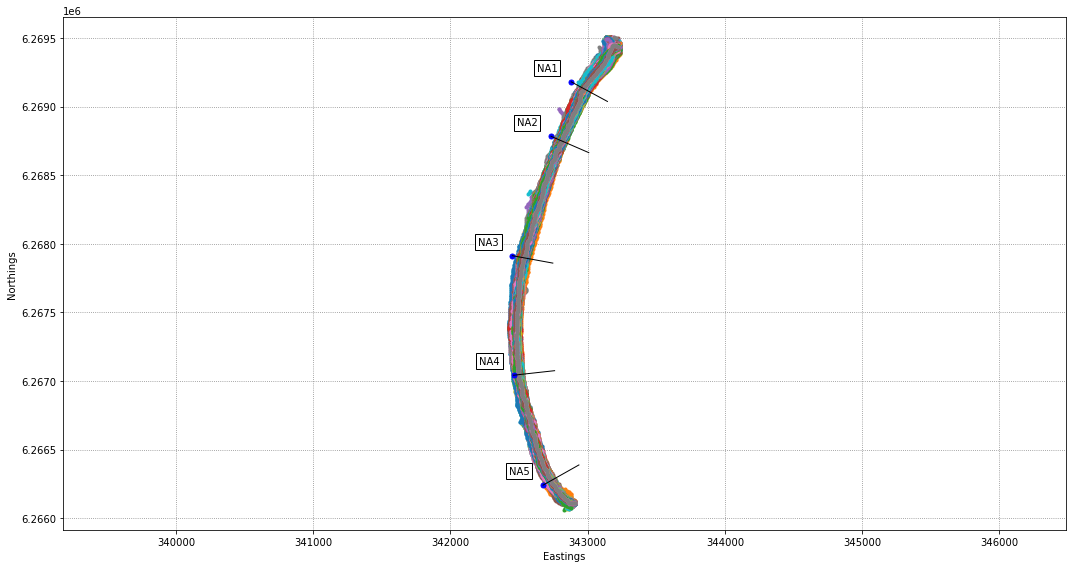

In [12]:
%matplotlib inline
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
                va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))

### 3. Shoreline analysis

In this section we show how to compute time-series of cross-shore distance along the transects.

**If you have already mapped the shorelines**, just load the output file (`output.pkl`) by running the section below

In [13]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f) 

Intersect the transects with the 2D shorelines to obtain time-series of cross-shore distance. A few additional settings are used in this automated version for quality-control.

In [14]:
settings_transects = { # parameters for shoreline intersections
                      'along_dist':         25,             # along-shore distance to use for intersection
                      'max_std':            15,             # max std for points around transect
                      'max_range':          30,             # max range for points around transect
                      'min_val':            -100,           # largest negative value along transect (landwards of transect origin)
                      # parameters for outlier removal
                      'nan/max':            'auto',         # mode for removing outliers ('auto', 'nan', 'max')
                      'prc_std':            0.1,            # percentage to use in 'auto' mode to switch from 'nan' to 'max'
                      'otsu_threshold':     [-.5,0],        # min and max intensity threshold use for contouring the shoreline
                      'max_cross_change':   40,             # two values of max_cross_change distance to use
                      'plot_fig':           False,           # whether to plot the intermediate steps
                      }
cross_distance = SDS_transects.compute_intersection(output, transects, settings_transects) 

Load the modelled tides from a file and find the tide levels at the time of image acquisition.

Extracting closest points: 100%

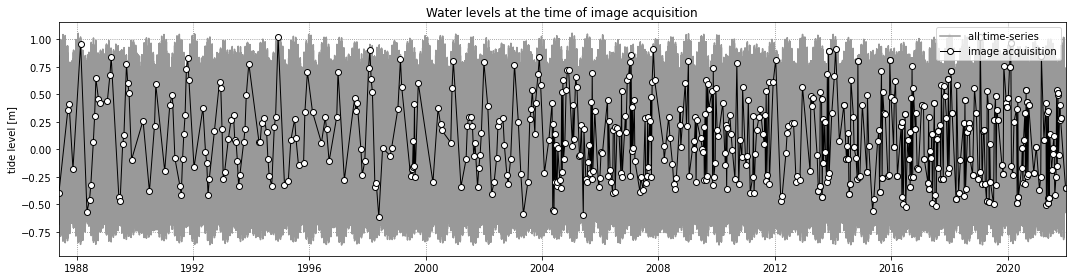

In [17]:
# load the modelled tides
tide_file = os.path.join(os.getcwd(), 'examples', 'NARRA_tides.csv')
tide_data = pd.read_csv(tide_file, parse_dates=['dates'])
dates_ts = [_.to_pydatetime() for _ in tide_data['dates']]
dates_ts = [pytz.utc.localize(_) for _ in dates_ts]
tides_ts = np.array(tide_data['tides'])
# get tide levels corresponding to the time of image acquisition
dates_sat = output['dates']
tides_sat = SDS_tools.get_closest_datapoint(dates_sat, dates_ts, tides_ts)

# plot the subsampled tide data
fig, ax = plt.subplots(1,1,figsize=(15,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(tide_data['dates'], tide_data['tides'], '-', color='0.6', label='all time-series')
ax.plot(dates_sat, tides_sat, '-o', color='k', ms=6, mfc='w',lw=1, label='image acquisition')
ax.set(ylabel='tide level [m]',xlim=[dates_sat[0],dates_sat[-1]], title='Water levels at the time of image acquisition');
ax.legend();

Apply the tidal correction with an estimate of the beach-face slope. Reference elevation is set to 0.7 m as this is MHWS at Narrabeen-Collaroy.

In [18]:
# apply tidal correction
beach_slope = 0.1           # estimate of the beach-face slope
reference_elevation = 0.7   # elevation at which you would like the shoreline time-series to be
cross_distance_corrected = {}
for key in cross_distance.keys():
    correction = (tides_sat-reference_elevation)/beach_slope
    cross_distance_corrected[key] = cross_distance[key] + correction

Remove outliers in the time-series with a depsiking algorithm.

In [19]:
cross_distance = SDS_transects.reject_outliers(cross_distance_corrected,output,settings_transects)

Finally, store the time-series of shoreline change in a .csv file

In [20]:
out_dict = dict([])
out_dict['dates'] = dates_sat
for key in cross_distance.keys():
    out_dict['Transect '+ key] = cross_distance[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                  'transect_time_series_tidally_corrected.csv')
df.to_csv(fn, sep=',')
print('Tidally-corrected time-series of the shoreline change along the transects saved as:\n%s'%fn)

Tidally-corrected time-series of the shoreline change along the transects saved as:
C:\Users\z5030440\Downloads\CoastSat\data\NARRA\transect_time_series_tidally_corrected.csv


### 4. Comparison to the surveyed data

Load in situ time-series of shorline change at the 0.7m contour and compare against the satellite-derived shoreline time-series.


In [21]:
filepath = os.path.join(os.getcwd(), 'examples')
with open(os.path.join(filepath, 'NARRA_groundtruth_07m' + '.pkl'), 'rb') as f:
    gt = pickle.load(f)
# convert timezone
for key in gt.keys():
    gt[key]['dates'] = [_.astimezone(pytz.utc) for _ in gt[key]['dates']]

Perform comparison between time-series and plot error metrics.

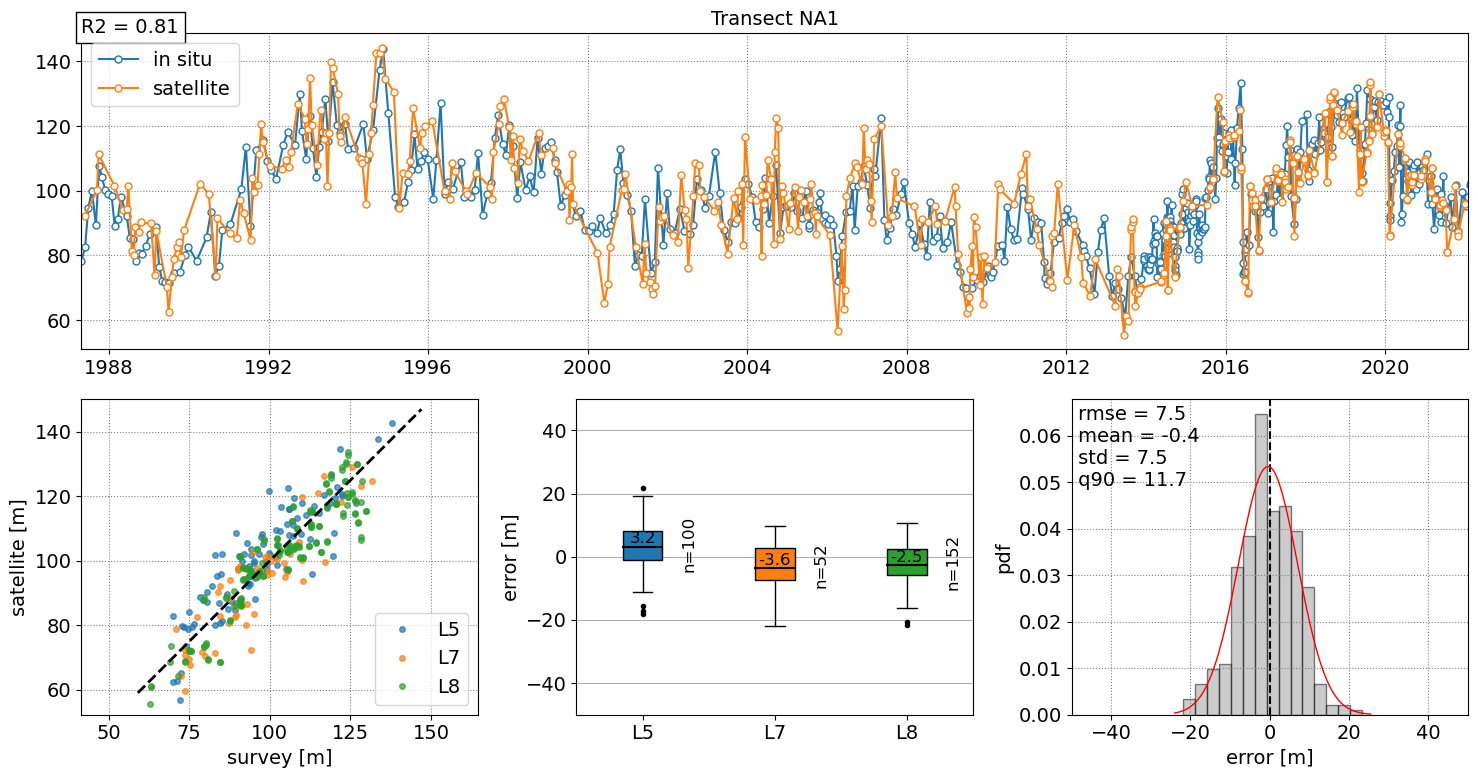

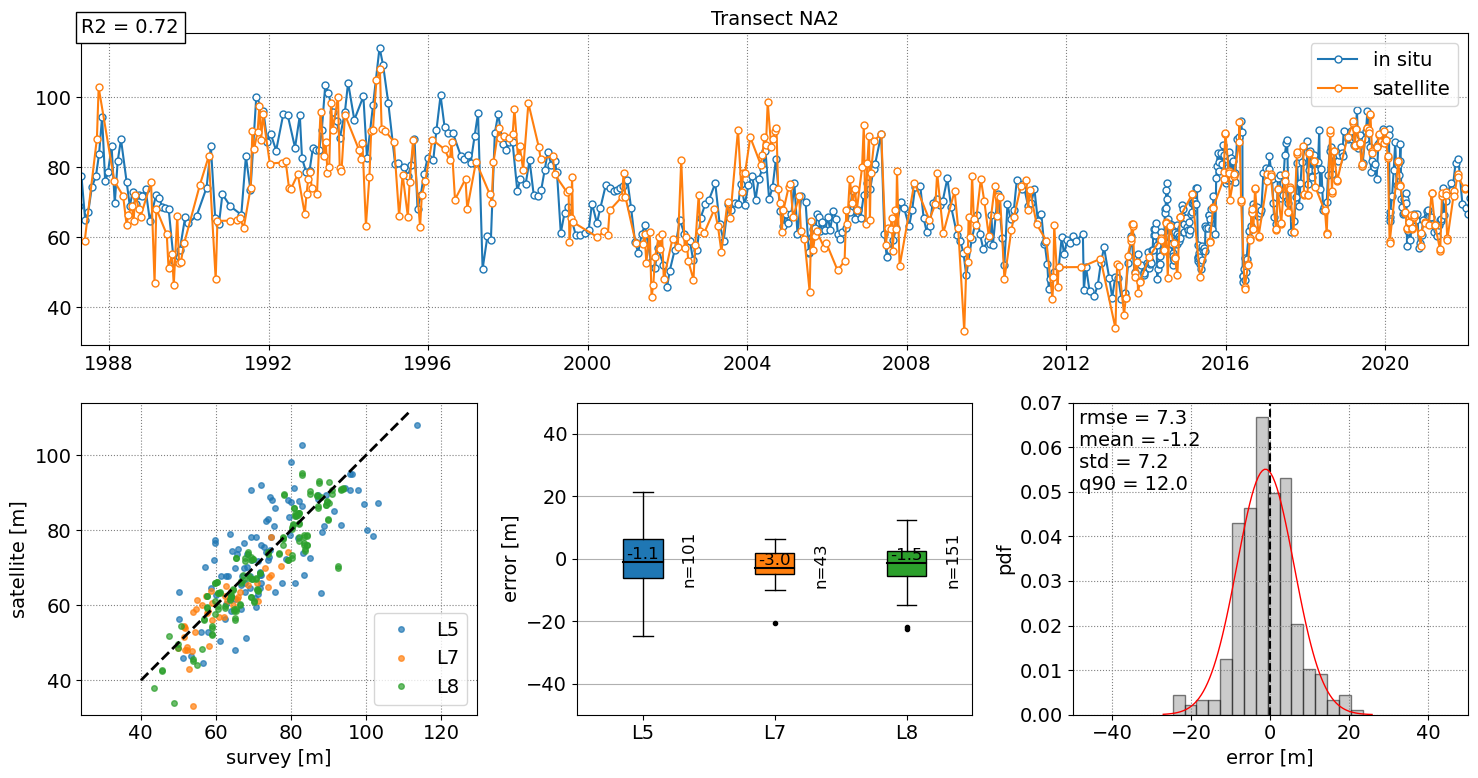

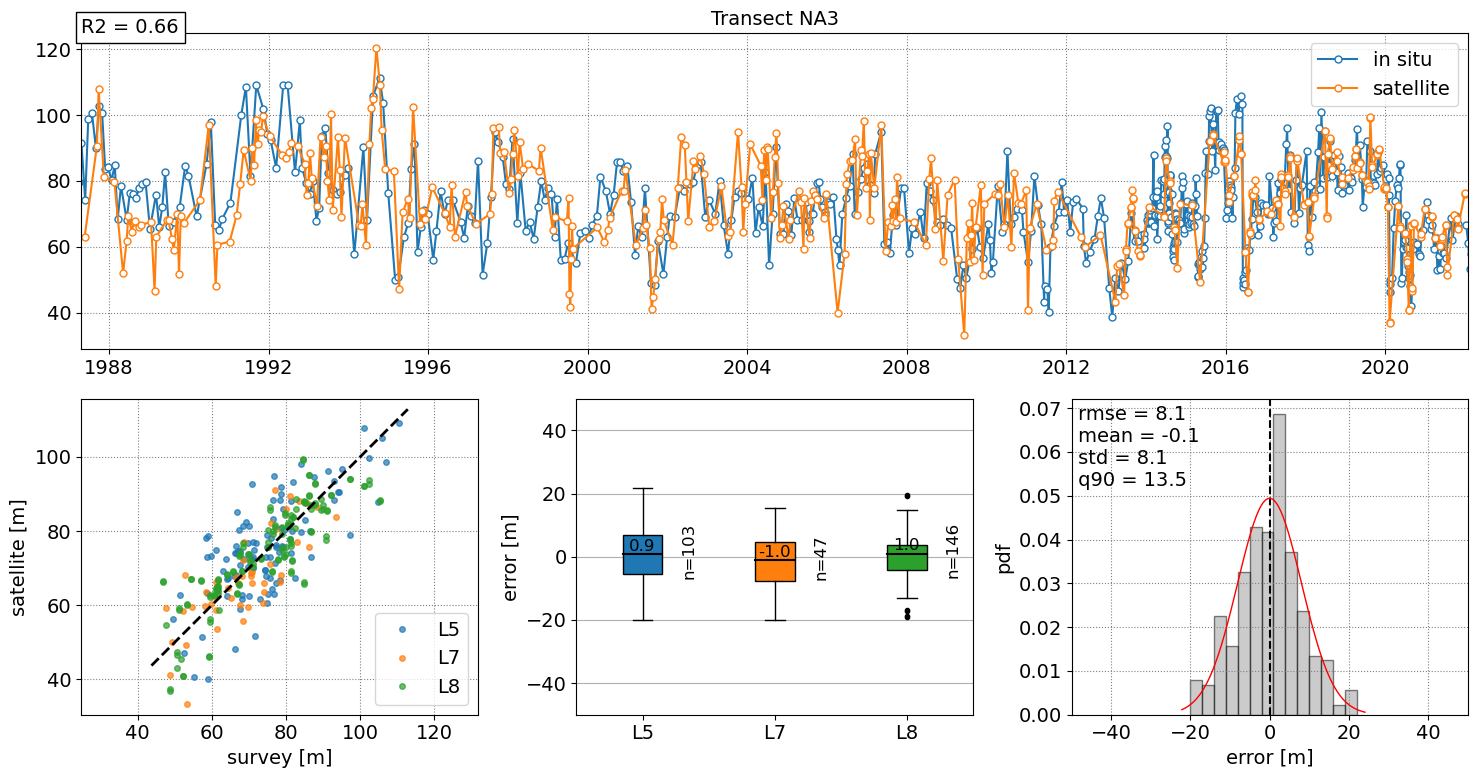

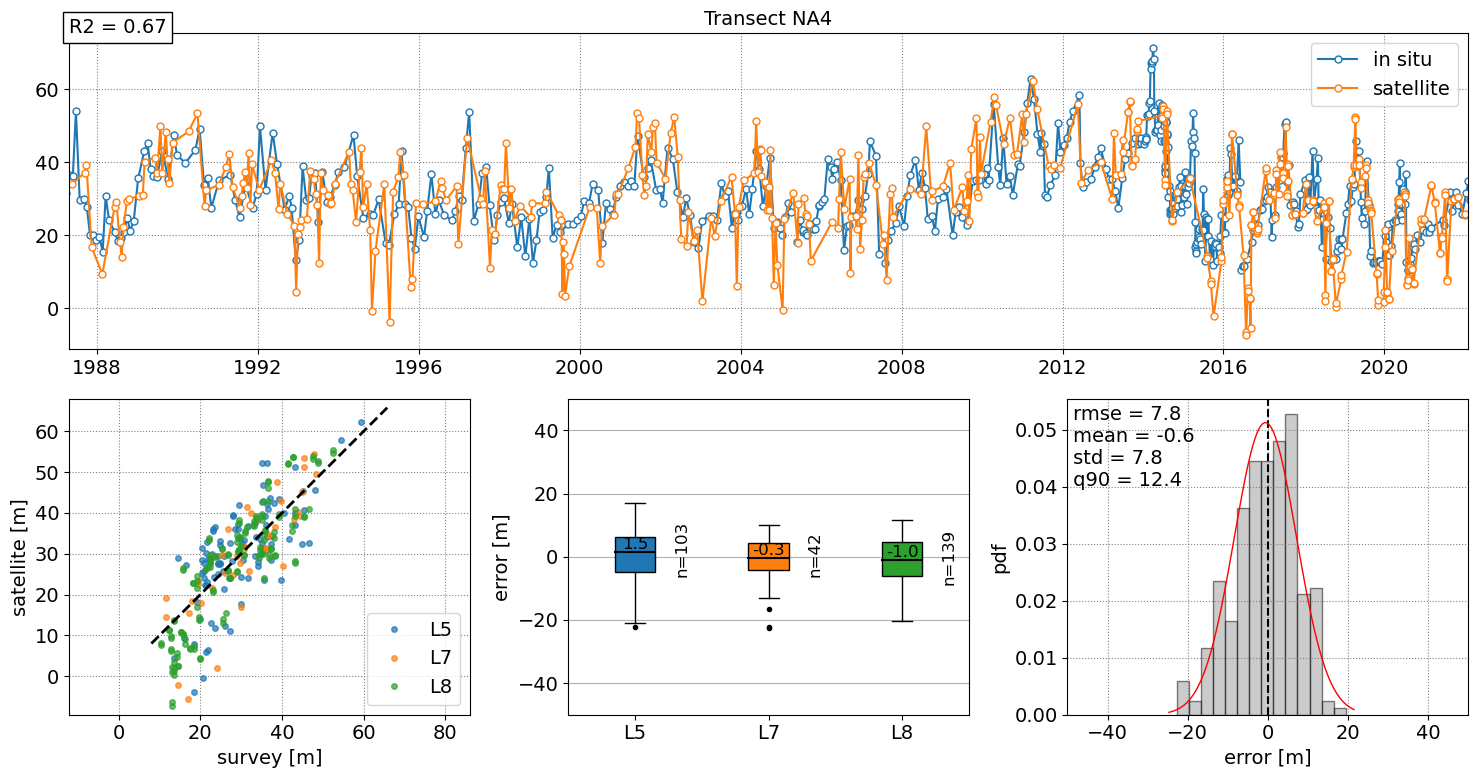

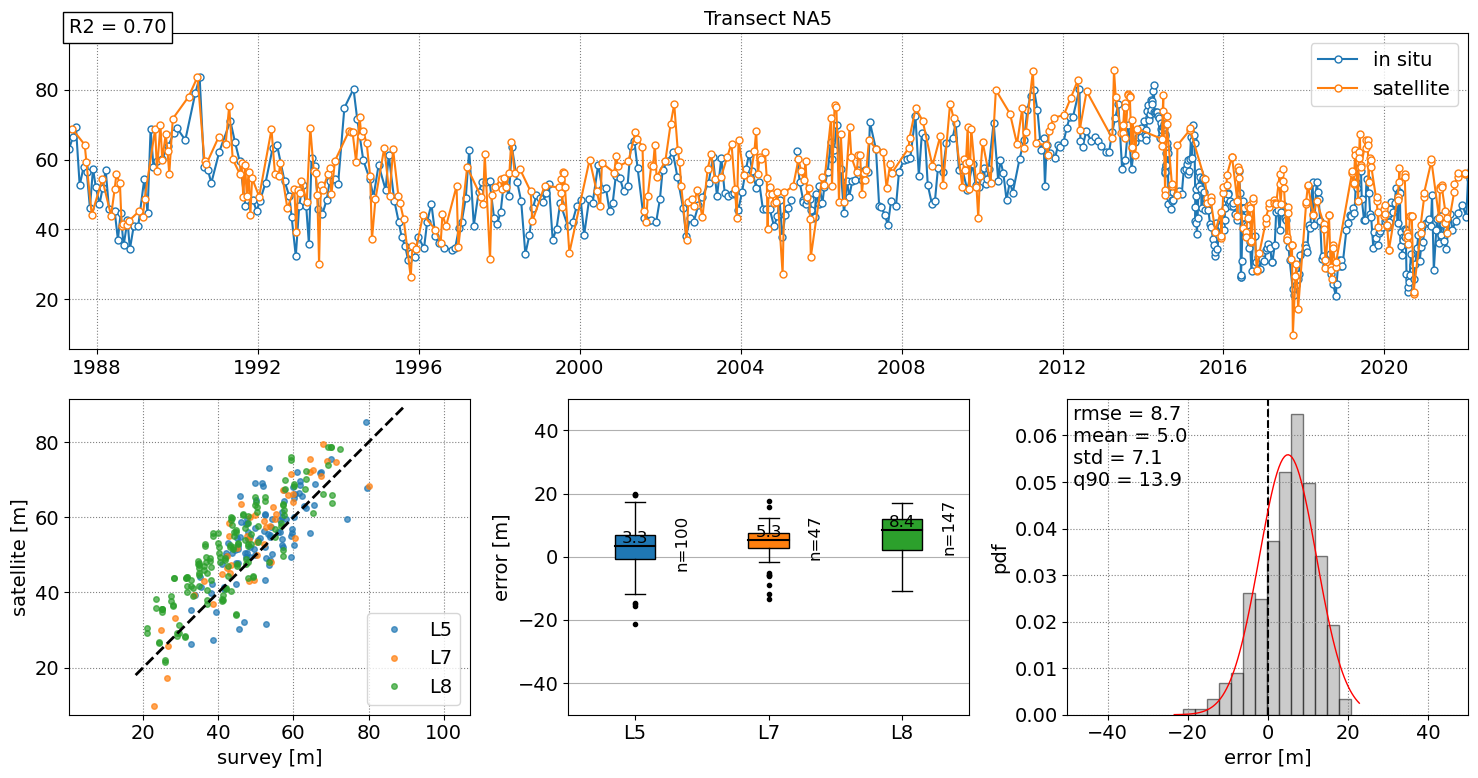

In [34]:
sett = {'min_days':3,'max_days':10, 'binwidth':3, 'lims':[-50,50]} 
chain_sat_all = []
chain_sur_all = [] 
satnames_all = []  
for key in transects.keys():
    
    # remove nans
    chainage = cross_distance[key]
    idx_nan = np.isnan(chainage)
    dates_nonans = [output['dates'][k] for k in np.where(~idx_nan)[0]]
    satnames_nonans = [output['satname'][k] for k in np.where(~idx_nan)[0]]
    chain_nonans = chainage[~idx_nan]
    
    # calculate the mean shoreline position since 1987 from surveyed data
    # mean = np.nanmean(gt[key]['chainage'][[np.logical_and(_>dates_nonans[0],_<dates_nonans[-1]) for _ in gt[key]['dates']]])
    
    chain_sat_dm = chain_nonans
    chain_sur_dm = gt[key]['chainage']
    
    # plot the time-series
    fig= plt.figure(figsize=[15,8], tight_layout=True)
    gs = gridspec.GridSpec(2,3)
    ax0 = fig.add_subplot(gs[0,:])
    ax0.grid(which='major',linestyle=':',color='0.5')
    ax0.plot(gt[key]['dates'], chain_sur_dm, 'o-',mfc='w',ms=5,label='in situ')
    ax0.plot(dates_nonans, chain_sat_dm,'-o',mfc='w',ms=5,label='satellite')
    ax0.set(title= 'Transect ' + key, xlim=[output['dates'][0]-timedelta(days=30),
                                           output['dates'][-1]+timedelta(days=30)])#,ylim=sett['lims'])
    ax0.legend()
    
    # interpolate surveyed data around satellite data
    chain_int = np.nan*np.ones(len(dates_nonans))
    for k,date in enumerate(dates_nonans):
        # compute the days distance for each satellite date 
        days_diff = np.array([ (_ - date).days for _ in gt[key]['dates']])
        # if nothing within 10 days put a nan
        if np.min(np.abs(days_diff)) > sett['max_days']:
            chain_int[k] = np.nan
        else:
            # if a point within 3 days, take that point (no interpolation)
            if np.min(np.abs(days_diff)) < sett['min_days']:
                idx_closest = np.where(np.abs(days_diff) == np.min(np.abs(days_diff)))
                chain_int[k] = float(gt[key]['chainage'][idx_closest[0][0]])
            else: # otherwise, between 3 and 10 days, interpolate between the 2 closest points
                if sum(days_diff > 0) == 0:
                    break
                idx_after = np.where(days_diff > 0)[0][0]
                idx_before = idx_after - 1
                x = [gt[key]['dates'][idx_before].toordinal() , gt[key]['dates'][idx_after].toordinal()]
                y = [gt[key]['chainage'][idx_before], gt[key]['chainage'][idx_after]]
                f = interpolate.interp1d(x, y,bounds_error=True)
                chain_int[k] = float(f(date.toordinal()))
    
    # remove nans again
    idx_nan = np.isnan(chain_int)
    chain_sat = chain_nonans[~idx_nan]
    chain_sur = chain_int[~idx_nan]
    dates_sat = [dates_nonans[k] for k in np.where(~idx_nan)[0]]
    satnames = [satnames_nonans[k] for k in np.where(~idx_nan)[0]]
    chain_sat_all = np.append(chain_sat_all,chain_sat)
    chain_sur_all = np.append(chain_sur_all,chain_sur)
    satnames_all = satnames_all + satnames
    
    # error statistics
    slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur, chain_sat)
    R2 = rvalue**2 
    ax0.text(0,1,'R2 = %.2f'%R2,bbox=dict(boxstyle='square', facecolor='w', alpha=1),transform=ax0.transAxes)
    chain_error = chain_sat - chain_sur
    rmse = np.sqrt(np.mean((chain_error)**2))
    mean = np.mean(chain_error)
    std = np.std(chain_error)
    q90 = np.percentile(np.abs(chain_error), 90)
    
    # 1:1 plot
    ax1 = fig.add_subplot(gs[1,0])
    ax1.axis('equal')
    ax1.grid(which='major',linestyle=':',color='0.5')
    for k,sat in enumerate(list(np.unique(satnames))): 
        idx = np.where([_ == sat for _ in satnames])[0]
        ax1.plot(chain_sur[idx], chain_sat[idx], 'o', ms=4, mfc='C'+str(k),mec='C'+str(k), alpha=0.7, label=sat)
    ax1.legend(loc=4)
    ax1.plot([ax1.get_xlim()[0], ax1.get_ylim()[1]],[ax1.get_xlim()[0], ax1.get_ylim()[1]],'k--',lw=2)
    ax1.set(xlabel='survey [m]', ylabel='satellite [m]')

    # boxplots
    ax2 = fig.add_subplot(gs[1,1])
    data = []
    median_data = []
    n_data = []
    ax2.yaxis.grid()
    for k,sat in enumerate(list(np.unique(satnames))):
        idx = np.where([_ == sat for _ in satnames])[0]
        data.append(chain_error[idx])
        median_data.append(np.median(chain_error[idx]))
        n_data.append(len(chain_error[idx]))
    bp = ax2.boxplot(data,0,'k.', labels=list(np.unique(satnames)), patch_artist=True)
    for median in bp['medians']:
        median.set(color='k', linewidth=1.5)
    for j,boxes in enumerate(bp['boxes']):
        boxes.set(facecolor='C'+str(j))
        ax2.text(j+1,median_data[j]+1, '%.1f' % median_data[j], horizontalalignment='center', fontsize=12)
        ax2.text(j+1+0.35,median_data[j]+1, ('n=%.d' % int(n_data[j])), ha='center', va='center', fontsize=12, rotation='vertical')
    ax2.set(ylabel='error [m]', ylim=sett['lims'])
    
    # histogram
    ax3 = fig.add_subplot(gs[1,2])
    ax3.grid(which='major',linestyle=':',color='0.5')
    ax3.axvline(x=0, ls='--', lw=1.5, color='k')
    binwidth=sett['binwidth']
    bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
    density = plt.hist(chain_error, bins=bins, density=True, color='0.6', edgecolor='k', alpha=0.5)
    mu, std = stats.norm.fit(chain_error)
    pval = stats.normaltest(chain_error)[1]
    xlims = ax3.get_xlim()
    x = np.linspace(xlims[0], xlims[1], 100)
    p = stats.norm.pdf(x, mu, std)
    ax3.plot(x, p, 'r-', linewidth=1)
    ax3.set(xlabel='error [m]', ylabel='pdf', xlim=sett['lims'])   
    str_stats = ' rmse = %.1f\n mean = %.1f\n std = %.1f\n q90 = %.1f' % (rmse, mean, std, q90) 
    ax3.text(0, 0.98, str_stats,va='top', transform=ax3.transAxes)
    
    # fig.savefig('transect_' + key + '.jpg', dpi=150)

Calculate statistics for all transects together.

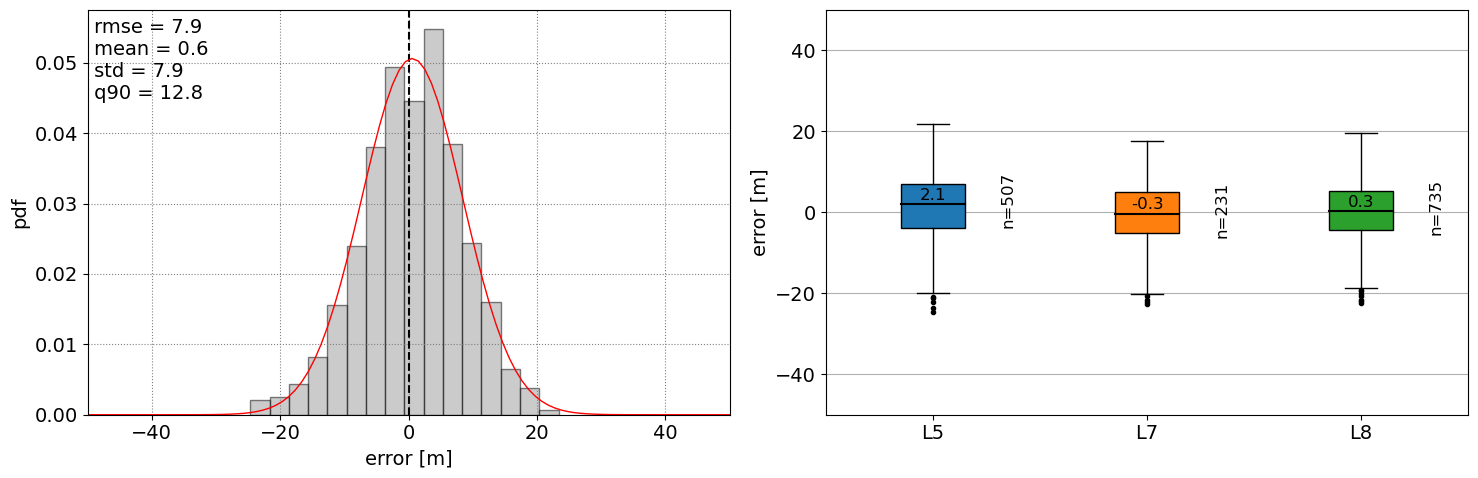

In [35]:
# calculate statistics for all transects together
chain_error = chain_sat_all - chain_sur_all        
slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur, chain_sat) 
R2 = rvalue**2
rmse = np.sqrt(np.mean((chain_error)**2))
mean = np.mean(chain_error)
std = np.std(chain_error)
q90 = np.percentile(np.abs(chain_error), 90)

fig,ax = plt.subplots(1,2,figsize=(15,5), tight_layout=True)
# histogram
ax[0].grid(which='major',linestyle=':',color='0.5')
ax[0].axvline(x=0, ls='--', lw=1.5, color='k')
binwidth=sett['binwidth']
bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
density = ax[0].hist(chain_error, bins=bins, density=True, color='0.6', edgecolor='k', alpha=0.5)
mu, std = stats.norm.fit(chain_error)
pval = stats.normaltest(chain_error)[1]
xlims = ax3.get_xlim()
x = np.linspace(xlims[0], xlims[1], 100)
p = stats.norm.pdf(x, mu, std)
ax[0].plot(x, p, 'r-', linewidth=1)
ax[0].set(xlabel='error [m]', ylabel='pdf', xlim=sett['lims'])   
str_stats = ' rmse = %.1f\n mean = %.1f\n std = %.1f\n q90 = %.1f' % (rmse, mean, std, q90) 
ax[0].text(0, 0.98, str_stats,va='top', transform=ax[0].transAxes)

# boxplot
data = []
median_data = []
n_data = []
ax[1].yaxis.grid()
for k,sat in enumerate(list(np.unique(satnames_all))):
    idx = np.where([_ == sat for _ in satnames_all])[0]
    data.append(chain_error[idx])
    median_data.append(np.median(chain_error[idx]))
    n_data.append(len(chain_error[idx]))
bp = ax[1].boxplot(data,0,'k.', labels=list(np.unique(satnames_all)), patch_artist=True)
for median in bp['medians']:
    median.set(color='k', linewidth=1.5)
for j,boxes in enumerate(bp['boxes']):
    boxes.set(facecolor='C'+str(j))
    ax[1].text(j+1,median_data[j]+1, '%.1f' % median_data[j], horizontalalignment='center', fontsize=12)
    ax[1].text(j+1+0.35,median_data[j]+1, ('n=%.d' % int(n_data[j])), ha='center', va='center', fontsize=12, rotation='vertical')
ax[1].set(ylabel='error [m]', ylim=sett['lims']);